In [39]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from subhalo_count import *

# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('/home/aussing/sty.mplstyle')

In [40]:
UNITMASS = 1e10
LITTLEH = 0.6688
UNIT_LENGTH_FOR_PLOTS = 'Mpc'
npart_min = 20
npart_star_min = 1


In [41]:

def get_extent(halo_pos,extent):

    xmin,xmax  = halo_pos[0]-extent,halo_pos[0]+extent
    ymin,ymax  = halo_pos[1]-extent,halo_pos[1]+extent
    zmin,zmax  = halo_pos[2]-extent,halo_pos[2]+extent
    
    return xmin,xmax,ymin,ymax,zmin,zmax


In [42]:

def make_mask(pos_x,pos_y,pos_z,halo_pos,extent):
    xmin,xmax,ymin,ymax,zmin,zmax = get_extent(halo_pos,extent)
    
    x_mask = (pos_x>=xmin) & (pos_x<=xmax)
    y_mask = (pos_y>=ymin) & (pos_y<=ymax)
    z_mask = (pos_z>=zmin) & (pos_z<=zmax)
    
    pos_mask = x_mask & y_mask & z_mask

    return pos_mask

In [43]:
def get_sim_data(sim_directory,n_file):
    snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(n_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = np.round(snap_data['Header'].attrs['Redshift'],2)
    return snap_data, haloinfo_data, z

In [44]:
def subhalo_data(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    z = np.round(z,2)
    print(z)
    # unit_len = get_unit_len(snap_data)

    halo_pos   = np.array(haloinfo_data['Group']['GroupPos'], dtype=np.float64) #/ LITTLEH
    halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH
    R200c = np.array(haloinfo_data['Group']['Group_R_Crit200'], dtype=np.float64) #/ LITTLEH

    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0]

    # print(f"Redshift = {np.round(z,2)}")
    # print(f"main halo ID = {mass_mask[halo_mainID]}")
    # print(f"Main halo pos = {halo_pos[mass_mask[halo_mainID],:]*LITTLEH}")
    # print(f'M_200c = {np.round(halo_M200c[mass_mask[halo_mainID]]/1e10,3)*LITTLEH}e10 h^-1 Msun')
    # print(f"R_200c = {np.round((R200c[mass_mask[halo_mainID]]),4)*LITTLEH} {UNIT_LENGTH_FOR_PLOTS}") # *unit_len set_plot_len

    main_halo_only = True
    subhalo_halo_num = np.array(haloinfo_data['Subhalo']['SubhaloGroupNr'], dtype=np.float64)
    subhalo_rank       = np.array(haloinfo_data['Subhalo']['SubhaloRankInGr'], dtype=np.int32)

    subhalo_mass       = np.array(haloinfo_data['Subhalo']['SubhaloMass'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_mass_type  = np.array(haloinfo_data['Subhalo']['SubhaloMassType'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_len        = np.array(haloinfo_data['Subhalo']['SubhaloLen'],dtype=np.int32)
    subhalo_len_type   = np.array(haloinfo_data['Subhalo']['SubhaloLenType'],dtype=np.int32)
    subhalo_pos        = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 

    main_halo_subhalos = np.where(subhalo_halo_num==[mass_mask[halo_mainID]])

    subhalo_mass       = subhalo_mass[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    subhalo_mass_type  = subhalo_mass_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len        = subhalo_len[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len_type   = subhalo_len_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 

    subhalo_pos = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 
    subhalo_pos = subhalo_pos[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    # subhalo_pos_dif = subhalo_pos - halo_pos[mass_mask[halo_mainID],:]
    # print(f"subhalo rank 0 - {subhalo_pos[0,:]}")
    # print(f"subhalo rank 1 - {subhalo_pos[1,:]}\n")

    subhalo_dist = []
    for i in range(len(subhalo_pos)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = subhalo_pos[i] - halo_pos[mass_mask[halo_mainID],:]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))

    subhalo_dist = np.array(subhalo_dist)
    mask_dists = (subhalo_dist>0.01) #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))
    # print(subhalo_dist[mask_dists])
    test = subhalo_dist[mask_dists]

    mask = (subhalo_len>=npart_min) & (subhalo_len_type[:,4]>=npart_star_min) & (subhalo_dist>0.005)  #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))

    # print(mask)
    star_mass              = subhalo_mass_type[mask,4]
    star_mass_ordered      = np.argsort(star_mass)[::-1]
    star_mass              = star_mass[star_mass_ordered][np.where(star_mass[star_mass_ordered]>0)[0]]
    star_mass_sum          = np.cumsum(np.ones(star_mass.shape[0]))
    
    subhalo_radius = np.array(haloinfo_data['Subhalo']['SubhaloHalfmassRad'],dtype=np.float64) #/ LITTLEH #* unit_len
    subhalo_radius = subhalo_radius[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    
    return halo_pos[mass_mask[halo_mainID],:], star_mass_sum, z, subhalo_pos, subhalo_radius, R200c[mass_mask[halo_mainID]], subhalo_mass_type

In [45]:
sim_directory_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/'
sim_directory_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/'

sim_directory_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/'
sim_directory_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/'
i_file = 26
halo_pos_cdm_005, star_mass_sum_cdm_005, z, subhalo_pos_cdm_005, subhalo_radius_cdm_005, r_200c_cdm_005, subhalo_mass_type_cdm_005 = subhalo_data(sim_directory_cdm_005,i_file)
halo_pos_cdm_010, star_mass_sum_cdm_010, z, subhalo_pos_cdm_010, subhalo_radius_cdm_010, r_200c_cdm_010, subhalo_mass_type_cdm_010 = subhalo_data(sim_directory_cdm_010,i_file)

halo_pos_wdm_005, star_mass_sum_wdm_005, z, subhalo_pos_wdm_005, subhalo_radius_wdm_005, r_200c_wdm_005, subhalo_mass_type_wdm_005 = subhalo_data(sim_directory_wdm_005,i_file)
halo_pos_wdm_010, star_mass_sum_wdm_010, z, subhalo_pos_wdm_010, subhalo_radius_wdm_010, r_200c_wdm_010, subhalo_mass_type_wdm_010 = subhalo_data(sim_directory_wdm_010,i_file)

0.0
0.0
0.0
0.0


1
2
3
4
5
9
13
36


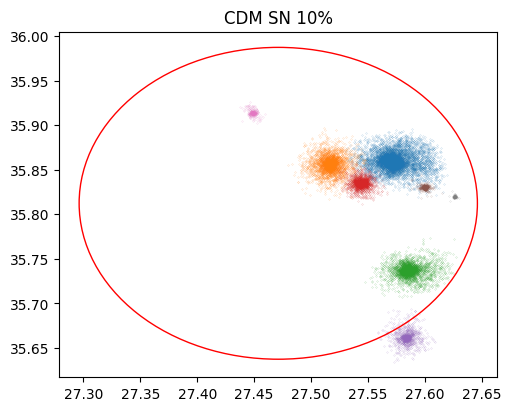

In [46]:
sim_dir_cdm_sn_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/'
snap_data_cdm_sn_010, haloinfo_data_cdm_sn_010, z = get_sim_data(sim_dir_cdm_sn_010,i_file)

snap_ids_dm_cdm_sn_010 = snap_data_cdm_sn_010['PartType1']['ParticleIDs']
dm_pos_cdm_sn_010 = snap_data_cdm_sn_010['PartType1']['Coordinates']
gas_pos_cdm_sn_010 = snap_data_cdm_sn_010['PartType0']['Coordinates']
star_pos_cdm_sn_010 = snap_data_cdm_sn_010['PartType4']['Coordinates']

subhalo_offset_type_cdm_sn_010 =  np.array(haloinfo_data_cdm_sn_010['Subhalo']['SubhaloOffsetType'], dtype=np.int64)
stel_subhalos_cdm_sn_010 = np.where(subhalo_mass_type_cdm_010[:,4]>0)[0]+1

fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=100,layout='constrained')

sub_id_all_list_cdm_sn_010 = np.zeros(1,dtype=np.int64)
for i in stel_subhalos_cdm_sn_010:
# for i in range(1,len(subhalo_mass_type_cdm_010)-1,1):
# for i in range(1,2,1):
    # print(i)
    sub_id_list = snap_ids_dm_cdm_sn_010[subhalo_offset_type_cdm_sn_010[i,1]:subhalo_offset_type_cdm_sn_010[(i+1),1]]
    sub_id_all_list_cdm_sn_010 = np.hstack((np.unique(sub_id_all_list_cdm_sn_010),sub_id_list))

    dm_pos_sub_cdm_sn_010 = dm_pos_cdm_sn_010[subhalo_offset_type_cdm_sn_010[i,1]:subhalo_offset_type_cdm_sn_010[(i+1),1]]
    plt.scatter(dm_pos_sub_cdm_sn_010[:,0],dm_pos_sub_cdm_sn_010[:,1], s=0.05,alpha=0.8,marker='.')
    
    star_pos_sub = star_pos_cdm_sn_010[subhalo_offset_type_cdm_sn_010[i,4]:subhalo_offset_type_cdm_sn_010[(i+1),4]]
    # plt.scatter(star_pos_sub[:,0],star_pos_sub[:,1], s=0.1,alpha=1,color='navy')

# for i in stel_subhalos_cdm_sn_010-1:
# for i in range(0,len(subhalo_mass_type_cdm_010),1):
    # ax1.add_patch(plt.Circle((subhalo_pos_cdm_010[i,0]*LITTLEH,subhalo_pos_cdm_010[i,1]*LITTLEH),subhalo_radius_cdm_010[i],fill=False,color='k',alpha=0.6,linewidth=0.5))

ax1.add_patch(plt.Circle((halo_pos_cdm_010[0],halo_pos_cdm_010[1]),r_200c_cdm_010, fill=False,color='red',alpha=1))
plt.title('CDM SN 10%')
sub_id_all_list_cdm_sn_010 = sub_id_all_list_cdm_sn_010[sub_id_all_list_cdm_sn_010>0]
reduced_id_list_cdm_sn_010 = np.isin(snap_ids_dm_cdm_sn_010,sub_id_all_list_cdm_sn_010)

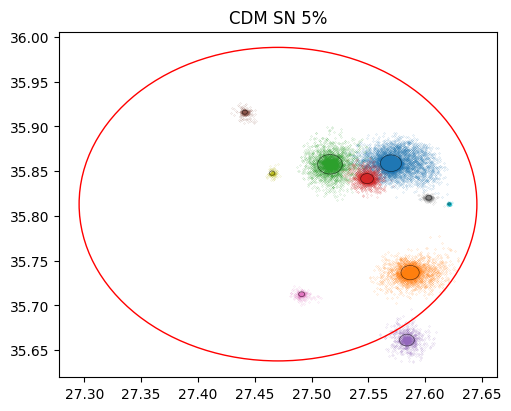

In [47]:
sim_dir_cdm_sn_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/'
snap_data_cdm_sn_005, haloinfo_data_cdm_sn_005, z = get_sim_data(sim_dir_cdm_sn_005,i_file)

snap_ids_dm_cdm_sn_005 = snap_data_cdm_sn_005['PartType1']['ParticleIDs']
dm_pos_cdm_sn_005 = snap_data_cdm_sn_005['PartType1']['Coordinates']
gas_pos_cdm_sn_005 = snap_data_cdm_sn_005['PartType0']['Coordinates']
star_pos_cdm_sn_005 = snap_data_cdm_sn_005['PartType4']['Coordinates']

subhalo_offset_type_cdm_sn_005 =  np.array(haloinfo_data_cdm_sn_005['Subhalo']['SubhaloOffsetType'], dtype=np.int64)
stel_subhalos_cdm_sn_005 = np.where(subhalo_mass_type_cdm_005[:,4]>0)[0]+1

fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=100,layout='constrained')

sub_id_all_list_cdm_sn_005 = np.zeros(1,dtype=np.int64)
for i in stel_subhalos_cdm_sn_005:
# for i in range(1,len(subhalo_mass_type_cdm_005)-1,1):
    sub_id_list = snap_ids_dm_cdm_sn_005[subhalo_offset_type_cdm_sn_005[i,1]:subhalo_offset_type_cdm_sn_005[(i+1),1]]
    sub_id_all_list_cdm_sn_005 = np.hstack((np.unique(sub_id_all_list_cdm_sn_005),sub_id_list))

    dm_pos_sub_cdm_sn_005 = dm_pos_cdm_sn_005[subhalo_offset_type_cdm_sn_005[i,1]:subhalo_offset_type_cdm_sn_005[(i+1),1]]
    plt.scatter(dm_pos_sub_cdm_sn_005[:,0],dm_pos_sub_cdm_sn_005[:,1], s=0.05,alpha=0.8,marker='.')
    
    star_pos_sub = star_pos_cdm_sn_005[subhalo_offset_type_cdm_sn_005[i,4]:subhalo_offset_type_cdm_sn_005[(i+1),4]]
    # plt.scatter(star_pos_sub[:,0],star_pos_sub[:,1], s=0.1,alpha=1,color='navy')

for i in stel_subhalos_cdm_sn_005-1:
# for i in range(0,len(subhalo_mass_type_cdm_010),1):
    ax1.add_patch(plt.Circle((subhalo_pos_cdm_005[i,0]*LITTLEH,subhalo_pos_cdm_005[i,1]*LITTLEH),subhalo_radius_cdm_005[i],fill=False,color='k',alpha=0.6,linewidth=0.5))

ax1.add_patch(plt.Circle((halo_pos_cdm_005[0],halo_pos_cdm_005[1]),r_200c_cdm_005, fill=False,color='red',alpha=1))
plt.title('CDM SN 5%')
sub_id_all_list_cdm_sn_005 = sub_id_all_list_cdm_sn_005[sub_id_all_list_cdm_sn_005>0]
reduced_id_list_cdm_sn_005 = np.isin(snap_ids_dm_cdm_sn_005,sub_id_all_list_cdm_sn_005)

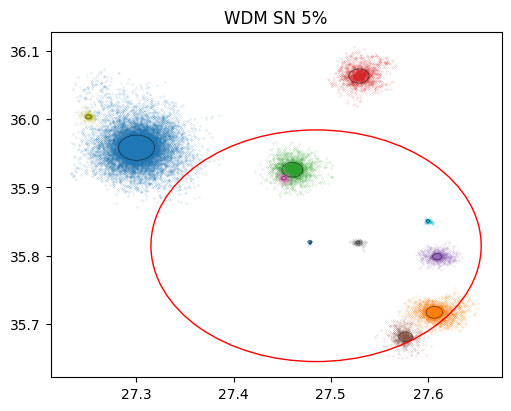

In [48]:
sim_dir_wdm_sn_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/'
snap_data_wdm_sn_005, haloinfo_data_wdm_sn_005, z = get_sim_data(sim_dir_wdm_sn_005,i_file)

snap_ids_dm_wdm_sn_005 = snap_data_wdm_sn_005['PartType1']['ParticleIDs']
dm_pos_wdm_sn_005 = snap_data_wdm_sn_005['PartType1']['Coordinates']
gas_pos_wdm_sn_005 = snap_data_wdm_sn_005['PartType0']['Coordinates']
star_pos_wdm_sn_005 = snap_data_wdm_sn_005['PartType4']['Coordinates']

subhalo_offset_type_wdm_sn_005 =  np.array(haloinfo_data_wdm_sn_005['Subhalo']['SubhaloOffsetType'], dtype=np.int64)
stel_subhalos_wdm_sn_005 = np.where(subhalo_mass_type_wdm_005[:,4]>0)[0]+1

fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=100,layout='constrained')

sub_id_all_list_wdm_sn_005 = np.zeros(1,dtype=np.int64)
for i in stel_subhalos_wdm_sn_005:
# for i in range(1,len(subhalo_mass_type_wdm_005)-1,1):
# for i in range(1,2,1):
    sub_id_list = snap_ids_dm_wdm_sn_005[subhalo_offset_type_wdm_sn_005[i,1]:subhalo_offset_type_wdm_sn_005[(i+1),1]]
    sub_id_all_list_wdm_sn_005 = np.hstack((np.unique(sub_id_all_list_wdm_sn_005),sub_id_list))
    
#     dm_pos_sub_wdm_sn_005 = dm_pos_wdm_sn_005[subhalo_offset_type_wdm_sn_005[i,1]:subhalo_offset_type_wdm_sn_005[(i+1),1]]
#     plt.scatter(dm_pos_sub_wdm_sn_005[:,0],dm_pos_sub_wdm_sn_005[:,1], s=0.05,alpha=0.8,marker='.')
    
#     star_pos_sub_wdm_sn_005 = star_pos_wdm_sn_005[subhalo_offset_type_wdm_sn_005[i,4]:subhalo_offset_type_wdm_sn_005[(i+1),4]]
#     # plt.scatter(star_pos_sub[:,0],star_pos_sub[:,1], s=0.1,alpha=1,color='navy')

# for i in stel_subhalos_wdm_sn_005-1:
# # for i in range(0,len(subhalo_mass_type_cdm_010),1):
#     ax1.add_patch(plt.Circle((subhalo_pos_wdm_005[i,0]*LITTLEH,subhalo_pos_wdm_005[i,1]*LITTLEH),subhalo_radius_wdm_005[i],fill=False,color='k',alpha=0.6,linewidth=0.5))

ax1.add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='red',alpha=1))
plt.title('WDM SN 5%')
sub_id_all_list_wdm_sn_005 = sub_id_all_list_wdm_sn_005[sub_id_all_list_wdm_sn_005>0]
reduced_id_list_wdm_sn_005 = np.isin(snap_ids_dm_wdm_sn_005,sub_id_all_list_wdm_sn_005)


In [61]:
sub_id_all_list_wdm_sn_005
# reduced_id_list_wdm_sn_005

array([27532792, 27532793, 27532794, ..., 32693614, 32770837, 32771123])

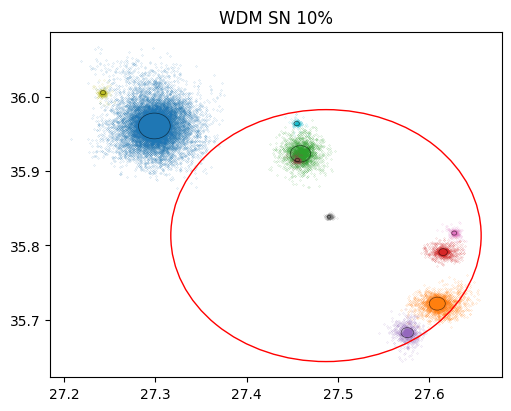

In [49]:
sim_dir_wdm_sn_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/'
snap_data_wdm_sn_010, haloinfo_data_wdm_sn_010, z = get_sim_data(sim_dir_wdm_sn_010,i_file)

snap_ids_dm_wdm_sn_010 = snap_data_wdm_sn_010['PartType1']['ParticleIDs']
dm_pos_wdm_sn_010 = snap_data_wdm_sn_010['PartType1']['Coordinates']
gas_pos_wdm_sn_010 = snap_data_wdm_sn_010['PartType0']['Coordinates']
star_pos_wdm_sn_010 = snap_data_wdm_sn_010['PartType4']['Coordinates']

subhalo_offset_type_wdm_sn_010 =  np.array(haloinfo_data_wdm_sn_010['Subhalo']['SubhaloOffsetType'], dtype=np.uint64)
stel_subhalos_wdm_sn_010 = np.where(subhalo_mass_type_wdm_010[:,4]>0)[0]+1

fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=100,layout='constrained')

sub_id_all_list_wdm_sn_010 = np.zeros(1,dtype=np.uint64)

for i in stel_subhalos_wdm_sn_010:
# for i in range(1,len(subhalo_mass_type_wdm_010)-1,1):
    
    sub_id_list = snap_ids_dm_wdm_sn_010[subhalo_offset_type_wdm_sn_010[i,1]:int(subhalo_offset_type_wdm_sn_010[(i+1),1]-1)]
    sub_id_all_list_wdm_sn_010 = np.hstack((np.unique(sub_id_all_list_wdm_sn_010),sub_id_list))
    
    dm_pos_sub_wdm_sn_010 = dm_pos_wdm_sn_010[subhalo_offset_type_wdm_sn_010[i,1]:subhalo_offset_type_wdm_sn_010[(i+1),1]]
    plt.scatter(dm_pos_sub_wdm_sn_010[:,0],dm_pos_sub_wdm_sn_010[:,1], s=0.05,alpha=0.8,marker='.')
    
    star_pos_sub_wdm_sn_010 = star_pos_wdm_sn_010[subhalo_offset_type_wdm_sn_010[i,4]:subhalo_offset_type_wdm_sn_010[(i+1),4]]
    # plt.scatter(star_pos_sub_wdm_sn_010[:,0],star_pos_sub_wdm_sn_010[:,1], s=0.1,alpha=1,color='navy')

for i in stel_subhalos_wdm_sn_010-1:
# for i in range(0,len(subhalo_mass_type_wdm_010),1):
    ax1.add_patch(plt.Circle((subhalo_pos_wdm_010[i,0]*LITTLEH,subhalo_pos_wdm_010[i,1]*LITTLEH),subhalo_radius_wdm_010[i],fill=False,color='k',alpha=0.6,linewidth=0.5))

ax1.add_patch(plt.Circle((halo_pos_wdm_010[0],halo_pos_wdm_010[1]),r_200c_wdm_010, fill=False,color='red',alpha=1))
plt.title('WDM SN 10%')

sub_id_all_list_wdm_sn_010 = sub_id_all_list_wdm_sn_010[sub_id_all_list_wdm_sn_010>0]
reduced_id_list_wdm_sn_010 = np.isin(snap_ids_dm_wdm_sn_010,sub_id_all_list_wdm_sn_010)

In [50]:
print(f'Num particles in subhaloes for cdm sn 5%  = {len(sub_id_all_list_cdm_sn_005)}')
print(f'Num particles in subhaloes for cdm sn 10% = {len(sub_id_all_list_cdm_sn_010)}')
print(f'Num particles in subhaloes for wdm sn 5%  = {len(sub_id_all_list_wdm_sn_005)}')
print(f'Num particles in subhaloes for wdm sn 10% = {len(sub_id_all_list_wdm_sn_010)}\n')


# #CDM 5 to CDM 10 both ways
# cdm_sn_5_in_cdm_sn_10_sub_sub = np.isin(sub_id_all_list_cdm_sn_005,sub_id_all_list_cdm_sn_010)
# cdm_sn_10_in_cdm_sn_5 = np.isin(sub_id_all_list_cdm_sn_010,sub_id_all_list_cdm_sn_005)

# #WDM 5 to WDM 10 both ways
# wdm_sn_5_in_wdm_sn_10_sub_sub = np.isin(sub_id_all_list_wdm_sn_005,sub_id_all_list_wdm_sn_010)
# wdm_sn_10_in_wdm_sn_5_sub_sub = np.isin(sub_id_all_list_wdm_sn_010,sub_id_all_list_wdm_sn_005)

#WDM 5 to CDM 10 both ways
wdm_sn_5_in_cdm_sn_10_sub_sub = np.isin(sub_id_all_list_wdm_sn_005,sub_id_all_list_cdm_sn_010)
cdm_sn_10_in_wdm_sn_5_sub_sub = np.isin(sub_id_all_list_cdm_sn_010,sub_id_all_list_wdm_sn_005)

# #WDM 10 to CDM 10 both ways
# wdm_sn_10_in_cdm_sn_10_sub_sub = np.isin(sub_id_all_list_wdm_sn_010,sub_id_all_list_cdm_sn_010)
# cdm_sn_10_in_wdm_sn_10_sub_sub = np.isin(sub_id_all_list_cdm_sn_010,sub_id_all_list_wdm_sn_010)

# #WDM 5 to CDM 5 both ways
# wdm_sn_5_in_cdm_sn_5_sub_sub = np.isin(sub_id_all_list_wdm_sn_005,sub_id_all_list_cdm_sn_005)
# cdm_sn_5_in_wdm_sn_5_sub_sub = np.isin(sub_id_all_list_cdm_sn_005,sub_id_all_list_wdm_sn_005)

# #WDM 10 to CDM 5 both ways
# wdm_sn_10_in_cdm_sn_5_sub_sub = np.isin(sub_id_all_list_wdm_sn_010,sub_id_all_list_cdm_sn_005)
# cdm_sn_5_in_wdm_sn_10_sub_sub = np.isin(sub_id_all_list_cdm_sn_005,sub_id_all_list_wdm_sn_010)

print('SubHalo correlations')

# #CDM 5 to CDM 10 both ways
# print(f'Percent CDM SN 5% in CDM SN 10% = {np.sum(cdm_sn_5_in_cdm_sn_10_sub_sub)/len(cdm_sn_5_in_cdm_sn_10_sub_sub)*100}')
# print(f'Percent CDM SN 10% in CDM SN 5% = {np.sum(cdm_sn_10_in_cdm_sn_5_sub_sub)/len(cdm_sn_10_in_cdm_sn_5_sub_sub)*100}')
# print()

# #WDM 5 to WDM 10 both ways
# print(f'Percent WDM SN 5% in WDM SN 10% = {np.sum(wdm_sn_5_in_wdm_sn_10_sub_sub)/len(wdm_sn_5_in_wdm_sn_10_sub_sub)*100}')
# print(f'Percent WDM SN 10% in WDM SN 5% = {np.sum(wdm_sn_10_in_wdm_sn_5_sub_sub)/len(wdm_sn_10_in_wdm_sn_5_sub_sub)*100}')
# print()

#WDM 5 to CDM 10 both ways
print(f'Percent WDM SN 5% in CDM SN 10% = {np.sum(wdm_sn_5_in_cdm_sn_10_sub_sub)/len(wdm_sn_5_in_cdm_sn_10_sub_sub)*100}')
print(f'Percent CDM SN 10% in WDM SN 5% = {np.sum(cdm_sn_10_in_wdm_sn_5_sub_sub)/len(cdm_sn_10_in_wdm_sn_5_sub_sub)*100}')
print()

# #WDM 10 to CDM 10 both ways
# print(f'Percent WDM SN 10% in CDM SN 10% = {np.sum(wdm_sn_10_in_cdm_sn_10_sub_sub)/len(wdm_sn_10_in_cdm_sn_10_sub_sub)*100}')
# print(f'Percent CDM SN 10% in WDM SN 10% = {np.sum(cdm_sn_10_in_wdm_sn_10_sub_sub)/len(cdm_sn_10_in_wdm_sn_10_sub_sub)*100}')
# print()

# #WDM 5 to CDM 5 both ways
# print(f'Percent WDM SN 5% in CDM SN 5% = {np.sum(wdm_sn_5_in_cdm_sn_5_sub_sub)/len(wdm_sn_5_in_cdm_sn_5_sub_sub)*100}')
# print(f'Percent CDM SN 5% in WDM SN 5% = {np.sum(cdm_sn_5_in_wdm_sn_5_sub_sub)/len(cdm_sn_5_in_wdm_sn_5_sub_sub)*100}')
# print()

# #WDM 10 to CDM 5 both ways
# print(f'Percent WDM SN 10% in CDM SN 5% = {np.sum(wdm_sn_10_in_cdm_sn_5_sub_sub)/len(wdm_sn_10_in_cdm_sn_5_sub_sub)*100}')
# print(f'Percent CDM SN 5% in WDM SN 10% = {np.sum(cdm_sn_5_in_wdm_sn_10_sub_sub)/len(cdm_sn_5_in_wdm_sn_10_sub_sub)*100}')
# print()

print(np.sum(wdm_sn_5_in_cdm_sn_10_sub_sub))
print(np.sum(cdm_sn_10_in_wdm_sn_5_sub_sub))


Num particles in subhaloes for cdm sn 5%  = 20542
Num particles in subhaloes for cdm sn 10% = 20554
Num particles in subhaloes for wdm sn 5%  = 36300
Num particles in subhaloes for wdm sn 10% = 34172

SubHalo correlations
Percent WDM SN 5% in CDM SN 10% = 46.107438016528924
Percent CDM SN 10% in WDM SN 5% = 81.42940546852195

16737
16737


Text(0.5, 1.0, 'WDM subhalo particles in CDM subhaloes ')

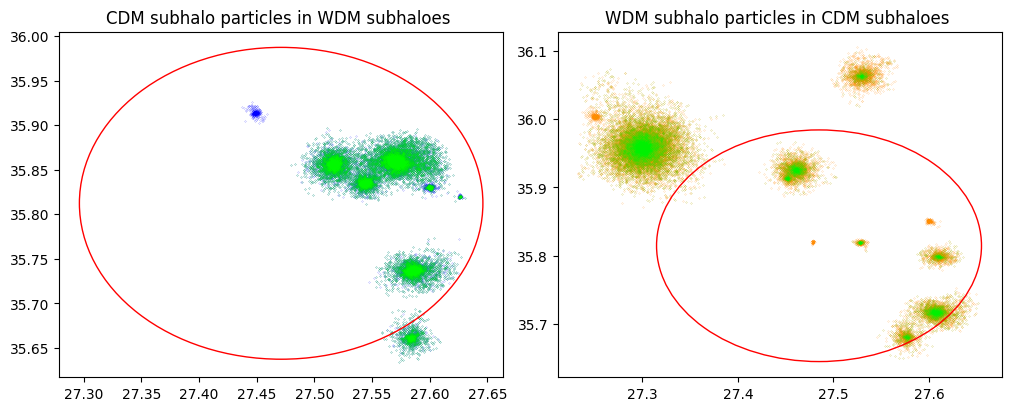

In [51]:
fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=100,layout='constrained')
axs[0].scatter(dm_pos_cdm_sn_010[:,0][reduced_id_list_cdm_sn_010],dm_pos_cdm_sn_010[:,1][reduced_id_list_cdm_sn_010], s=0.05,alpha=1,marker='.',color='blue')
axs[1].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005], s=0.05,alpha=1,marker='.',color='darkorange')

axs[0].scatter(dm_pos_cdm_sn_010[:,0][reduced_id_list_cdm_sn_010][cdm_sn_10_in_wdm_sn_5_sub_sub],dm_pos_cdm_sn_010[:,1][reduced_id_list_cdm_sn_010][cdm_sn_10_in_wdm_sn_5_sub_sub], s=0.05,alpha=1,marker='.',color='lime')
axs[1].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005][wdm_sn_5_in_cdm_sn_10_sub_sub],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005][wdm_sn_5_in_cdm_sn_10_sub_sub], s=0.05,alpha=0.4,marker='.',c='lime')

# for i in stel_subhalos_cdm_sn_005-1:
#     ax1.add_patch(plt.Circle((subhalo_pos_cdm_005[i,0]*LITTLEH,subhalo_pos_cdm_005[i,1]*LITTLEH),subhalo_radius_cdm_005[i],fill=False,color='r',alpha=1,linewidth=1))
axs[0].add_patch(plt.Circle((halo_pos_cdm_010[0],halo_pos_cdm_010[1]),r_200c_cdm_010, fill=False,color='red',alpha=1))
axs[1].add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='red',alpha=1))

axs[0].set_title('CDM subhalo particles in WDM subhaloes ')
axs[1].set_title('WDM subhalo particles in CDM subhaloes ')


In [52]:
offset_cdm_005 = int(subhalo_offset_type_cdm_sn_005[1,1]-1)
offset_cdm_010 = int(subhalo_offset_type_cdm_sn_010[1,1]-1)
offset_wdm_005 = int(subhalo_offset_type_wdm_sn_005[1,1]-1)
offset_wdm_010 = int(subhalo_offset_type_wdm_sn_010[1,1]-1)

central_ids_cdm_sn_005 = snap_ids_dm_cdm_sn_005[0:offset_cdm_005]
central_ids_cdm_sn_010 = snap_ids_dm_cdm_sn_010[0:offset_cdm_010]
central_ids_wdm_sn_005 = snap_ids_dm_wdm_sn_005[0:offset_wdm_005]
central_ids_wdm_sn_010 = snap_ids_dm_wdm_sn_010[0:offset_wdm_010]

In [53]:
print(f'Num particles in central halo for cdm sn 5%  = {len(central_ids_cdm_sn_005)}')
print(f'Num particles in central halo for cdm sn 10% = {len(central_ids_cdm_sn_010)}')
print(f'Num particles in central halo for wdm sn 5%  = {len(central_ids_wdm_sn_005)}')
print(f'Num particles in central halo for wdm sn 10% = {len(central_ids_wdm_sn_010)}\n')


#CDM 5 to CDM 10 both ways
cdm_sn_5_in_cdm_sn_10_main_main = np.isin(central_ids_cdm_sn_005,central_ids_cdm_sn_010)
cdm_sn_10_in_cdm_sn_5_main_main = np.isin(central_ids_cdm_sn_010,central_ids_cdm_sn_005)

#WDM 5 to WDM 10 both ways
wdm_sn_5_in_wdm_sn_10_main_main = np.isin(central_ids_wdm_sn_005,central_ids_wdm_sn_010)
wdm_sn_10_in_wdm_sn_5_main_main = np.isin(central_ids_wdm_sn_010,central_ids_wdm_sn_005)

#WDM 5 to CDM 10 both ways
wdm_sn_5_in_cdm_sn_10_main_main = np.isin(central_ids_wdm_sn_005,central_ids_cdm_sn_010)
cdm_sn_10_in_wdm_sn_5_main_main = np.isin(central_ids_cdm_sn_010,central_ids_wdm_sn_005)

#WDM 10 to CDM 10 both ways
wdm_sn_10_in_cdm_sn_10_main_main = np.isin(central_ids_wdm_sn_010,central_ids_cdm_sn_010)
cdm_sn_10_in_wdm_sn_10_main_main = np.isin(central_ids_cdm_sn_010,central_ids_wdm_sn_010)

#WDM 5 to CDM 5 both ways
wdm_sn_5_in_cdm_sn_5_main_main = np.isin(central_ids_wdm_sn_005,central_ids_cdm_sn_005)
cdm_sn_5_in_wdm_sn_5_main_main = np.isin(central_ids_cdm_sn_005,central_ids_wdm_sn_005)

#WDM 10 to CDM 5 both ways
wdm_sn_10_in_cdm_sn_5_main_main = np.isin(central_ids_wdm_sn_010,central_ids_cdm_sn_005)
cdm_sn_5_in_wdm_sn_10_main_main = np.isin(central_ids_cdm_sn_005,central_ids_wdm_sn_010)

print('Central Halo correlations')
# #CDM 5 to CDM 10 both ways
# print(f'Percent CDM SN 5% in CDM SN 10% = {np.sum(cdm_sn_5_in_cdm_sn_10_main_main)/len(cdm_sn_5_in_cdm_sn_10_main_main)*100}')
# print(f'Percent CDM SN 10% in CDM SN 5% = {np.sum(cdm_sn_10_in_cdm_sn_5_main_main)/len(cdm_sn_10_in_cdm_sn_5_main_main)*100}')
# print()

# #WDM 5 to WDM 10 both ways
# print(f'Percent WDM SN 5% in WDM SN 10% = {np.sum(wdm_sn_5_in_wdm_sn_10_main_main)/len(wdm_sn_5_in_wdm_sn_10_main_main)*100}')
# print(f'Percent WDM SN 10% in WDM SN 5% = {np.sum(wdm_sn_10_in_wdm_sn_5_main_main)/len(wdm_sn_10_in_wdm_sn_5_main_main)*100}')
# print()

#WDM 5 to CDM 10 both ways
print(f'Percent WDM SN 5% in CDM SN 10% = {np.sum(wdm_sn_5_in_cdm_sn_10_main_main)/len(wdm_sn_5_in_cdm_sn_10_main_main)*100}')
print(f'Percent CDM SN 10% in WDM SN 5% = {np.sum(cdm_sn_10_in_wdm_sn_5_main_main)/len(cdm_sn_10_in_wdm_sn_5_main_main)*100}')
print()

# #WDM 10 to CDM 10 both ways
# print(f'Percent WDM SN 10% in CDM SN 10% = {np.sum(wdm_sn_10_in_cdm_sn_10_main_main)/len(wdm_sn_10_in_cdm_sn_10_main_main)*100}')
# print(f'Percent CDM SN 10% in WDM SN 10% = {np.sum(cdm_sn_10_in_wdm_sn_10_main_main)/len(cdm_sn_10_in_wdm_sn_10_main_main)*100}')
# print()

# #WDM 5 to CDM 5 both ways
# print(f'Percent WDM SN 5% in CDM SN 5% = {np.sum(wdm_sn_5_in_cdm_sn_5_main_main)/len(wdm_sn_5_in_cdm_sn_5_main_main)*100}')
# print(f'Percent CDM SN 5% in WDM SN 5% = {np.sum(cdm_sn_5_in_wdm_sn_5_main_main)/len(cdm_sn_5_in_wdm_sn_5_main_main)*100}')
# print()

# #WDM 10 to CDM 5 both ways
# print(f'Percent WDM SN 10% in CDM SN 5% = {np.sum(wdm_sn_10_in_cdm_sn_5_main_main)/len(wdm_sn_10_in_cdm_sn_5_main_main)*100}')
# print(f'Percent CDM SN 5% in WDM SN 10% = {np.sum(cdm_sn_5_in_wdm_sn_10_main_main)/len(cdm_sn_5_in_wdm_sn_10_main_main)*100}')
# print()



Num particles in central halo for cdm sn 5%  = 430099
Num particles in central halo for cdm sn 10% = 428407
Num particles in central halo for wdm sn 5%  = 417026
Num particles in central halo for wdm sn 10% = 414578

Central Halo correlations
Percent WDM SN 5% in CDM SN 10% = 90.33345642717721
Percent CDM SN 10% in WDM SN 5% = 87.93367055160162



Text(0.5, 1.0, 'WDM central particles in CDM Central ')

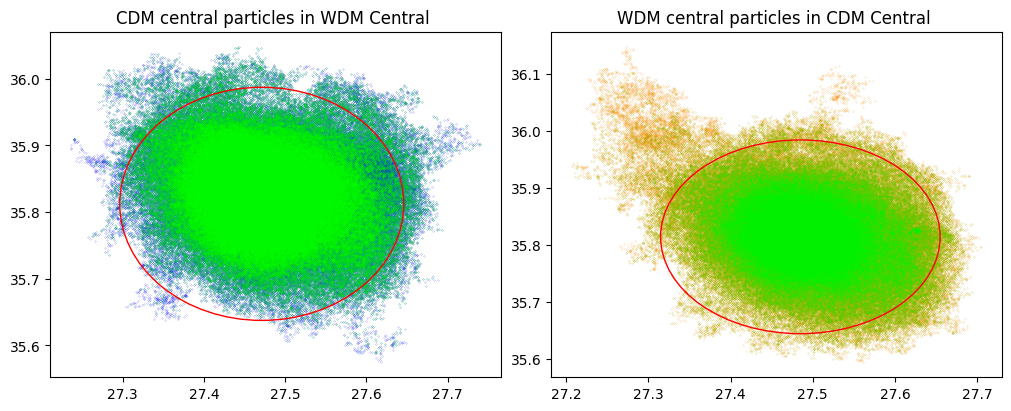

In [54]:
subhalo_offset_type_wdm_sn_010
fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=100,layout='constrained')
axs[0].scatter(dm_pos_cdm_sn_010[0:offset_cdm_010,0],dm_pos_cdm_sn_010[0:offset_cdm_010,1], s=0.05,alpha=1,marker='.',color='blue')
axs[1].scatter(dm_pos_wdm_sn_005[0:offset_wdm_005,0],dm_pos_wdm_sn_005[0:offset_wdm_005,1], s=0.05,alpha=1,marker='.',color='darkorange')

axs[0].scatter(dm_pos_cdm_sn_010[0:offset_cdm_010,0][cdm_sn_10_in_wdm_sn_5_main_main],dm_pos_cdm_sn_010[0:offset_cdm_010,1][cdm_sn_10_in_wdm_sn_5_main_main], s=0.05,alpha=1,marker='.',color='lime')
axs[1].scatter(dm_pos_wdm_sn_005[0:offset_wdm_005,0][wdm_sn_5_in_cdm_sn_10_main_main],dm_pos_wdm_sn_005[0:offset_wdm_005,1][wdm_sn_5_in_cdm_sn_10_main_main], s=0.05,alpha=0.4,marker='.',c='lime')

# for i in stel_subhalos_cdm_sn_005-1:
#     ax1.add_patch(plt.Circle((subhalo_pos_cdm_005[i,0]*LITTLEH,subhalo_pos_cdm_005[i,1]*LITTLEH),subhalo_radius_cdm_005[i],fill=False,color='r',alpha=1,linewidth=1))
axs[0].add_patch(plt.Circle((halo_pos_cdm_010[0],halo_pos_cdm_010[1]),r_200c_cdm_010, fill=False,color='red',alpha=1))
axs[1].add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='red',alpha=1))

axs[0].set_title('CDM central particles in WDM Central ')
axs[1].set_title('WDM central particles in CDM Central ')

In [55]:
###############
#### SUBS to central correlation
###############

#WDM 5 to CDM 10 both ways
wdm_sn_5_subs_in_cdm_sn_10_main = np.isin(sub_id_all_list_wdm_sn_005,central_ids_cdm_sn_010)
cdm_sn_10_main_in_wdm_sn_5_subs = np.isin(central_ids_cdm_sn_010,sub_id_all_list_wdm_sn_005)



#WDM 5 to CDM 10 both ways
wdm_sn_5_main_in_cdm_sn_10_subs = np.isin(central_ids_wdm_sn_005,sub_id_all_list_cdm_sn_010)
cdm_sn_10_subs_in_wdm_sn_5_main = np.isin(sub_id_all_list_cdm_sn_010,central_ids_wdm_sn_005)


print('SUBS to central correlation')

#WDM 5 Subs to CDM 10 main
print(f'Percent WDM SN 5% Subhaloes in CDM SN 10% Main halo = {np.sum(wdm_sn_5_subs_in_cdm_sn_10_main)/len(wdm_sn_5_subs_in_cdm_sn_10_main)*100}')
print(f'Percent CDM SN 10% Main halo in WDM SN 5% Subhaloes = {np.sum(cdm_sn_10_main_in_wdm_sn_5_subs)/len(cdm_sn_10_main_in_wdm_sn_5_subs)*100}')
print()

#WDM 5 Main to CDM 10 SUBS
print(f'Percent CDM SN 10% subhalos in WDM SN 5% main halo = {np.sum(cdm_sn_10_subs_in_wdm_sn_5_main)/len(cdm_sn_10_subs_in_wdm_sn_5_main)*100}')
print(f'Percent WDM SN 5% Main halo in CDM SN 10% subhalos = {np.sum(wdm_sn_5_main_in_cdm_sn_10_subs)/len(wdm_sn_5_main_in_cdm_sn_10_subs)*100}')
print()




SUBS to central correlation
Percent WDM SN 5% Subhaloes in CDM SN 10% Main halo = 34.41046831955923
Percent CDM SN 10% Main halo in WDM SN 5% Subhaloes = 2.9156853179336473

Percent CDM SN 10% subhalos in WDM SN 5% main halo = 14.08484966429892
Percent WDM SN 5% Main halo in CDM SN 10% subhalos = 0.6942013207809585



Total WDM subhalo particles in CDM 80.5%
Total missing 19.5%


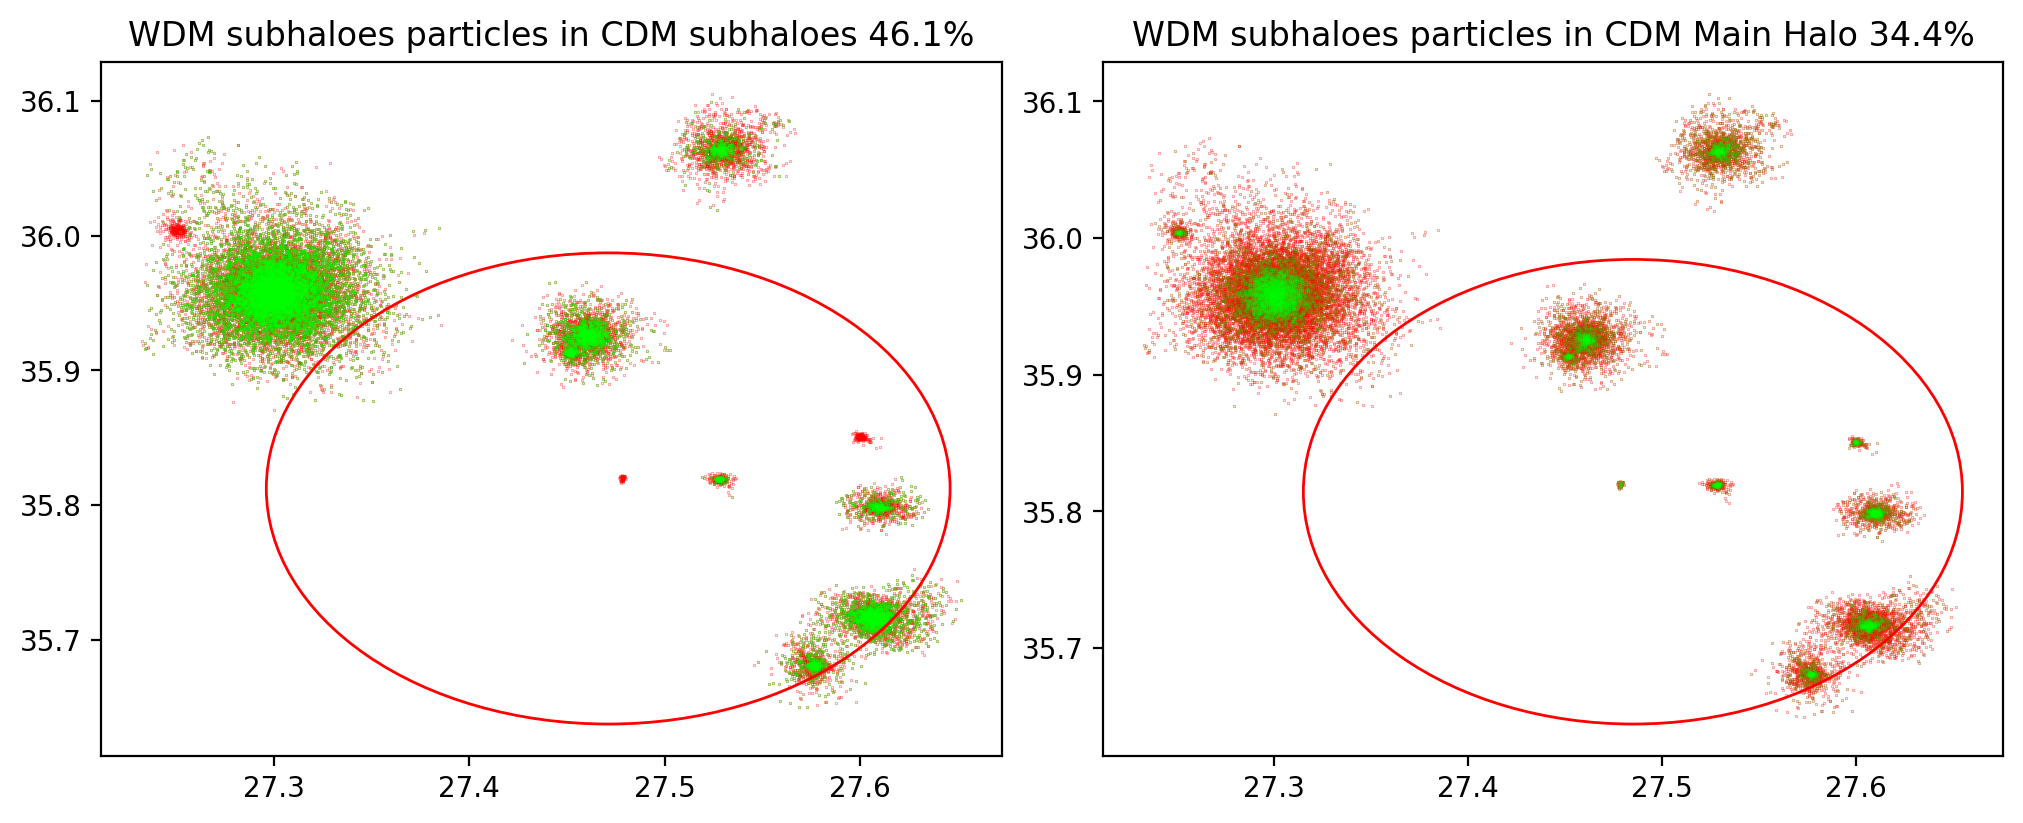

In [58]:
percent_wdm_sn_5_subs_in_cdm_sn_10_subs = np.round(np.sum(wdm_sn_5_in_cdm_sn_10_sub_sub)/len(wdm_sn_5_in_cdm_sn_10_sub_sub)*100,1)
percent_wdm_sn_5_subs_in_cdm_sn_10_main = np.round(np.sum(wdm_sn_5_subs_in_cdm_sn_10_main)/len(wdm_sn_5_subs_in_cdm_sn_10_main)*100,1)

fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=200,layout='constrained')
# axs[0].scatter(dm_pos_cdm_sn_010[:,0][reduced_id_list_cdm_sn_010],dm_pos_cdm_sn_010[:,1][reduced_id_list_cdm_sn_010], s=0.05,alpha=1,marker='.',color='blue')
axs[0].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005], s=0.05,alpha=1,marker='.',color='red')
axs[1].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005], s=0.05,alpha=1,marker='.',color='red')

# axs[0].scatter(dm_pos_cdm_sn_010[0:offset_cdm_010,0][cdm_sn_10_in_wdm_sn_5_main_main],dm_pos_cdm_sn_010[0:offset_cdm_010,1][cdm_sn_10_in_wdm_sn_5_main_main], s=0.05,alpha=1,marker='.',color='lime')
axs[0].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005][wdm_sn_5_in_cdm_sn_10_sub_sub],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005][wdm_sn_5_in_cdm_sn_10_sub_sub], s=0.05,alpha=1,marker='.',color='lime')
axs[1].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005][wdm_sn_5_subs_in_cdm_sn_10_main],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005][wdm_sn_5_subs_in_cdm_sn_10_main], s=0.05,alpha=0.4,marker='.',c='lime')

# for i in stel_subhalos_cdm_sn_005-1:
#     ax1.add_patch(plt.Circle((subhalo_pos_cdm_005[i,0]*LITTLEH,subhalo_pos_cdm_005[i,1]*LITTLEH),subhalo_radius_cdm_005[i],fill=False,color='r',alpha=1,linewidth=1))
axs[0].add_patch(plt.Circle((halo_pos_cdm_010[0],halo_pos_cdm_010[1]),r_200c_cdm_010, fill=False,color='red',alpha=1))
axs[1].add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='red',alpha=1))

axs[0].set_title(f'WDM subhaloes particles in CDM subhaloes {percent_wdm_sn_5_subs_in_cdm_sn_10_subs}%')
axs[1].set_title(f'WDM subhaloes particles in CDM Main Halo {percent_wdm_sn_5_subs_in_cdm_sn_10_main}%')

# axs[0].set_title('CDM central particles in WDM subhaloes ')
# axs[1].set_title('WDM central particles in CDM subhaloes ')
print(f"Total WDM subhalo particles in CDM {percent_wdm_sn_5_subs_in_cdm_sn_10_subs+percent_wdm_sn_5_subs_in_cdm_sn_10_main}%")
print(f"Total missing {np.round(100-(percent_wdm_sn_5_subs_in_cdm_sn_10_subs+percent_wdm_sn_5_subs_in_cdm_sn_10_main),1)}%")

7072


Text(0.5, 1.0, 'WDM subhaloes particles not in CDM 19.5%')

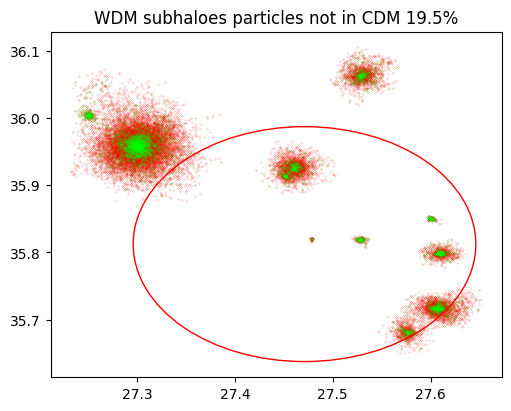

In [57]:
fig, axs = plt.subplots(1,1,figsize=(5,4),dpi=100,layout='constrained')

axs.scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005], s=0.05,alpha=1,marker='.',color='red')
# axs[1].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005], s=0.05,alpha=1,marker='.',color='red')

not_wdm_sn_5_in_cdm_sn_10_sub_sub = np.logical_not( np.logical_or(wdm_sn_5_in_cdm_sn_10_sub_sub , wdm_sn_5_subs_in_cdm_sn_10_main))
# not_wdm_sn_5_subs_in_cdm_sn_10_main = np.logical_not( )
print(np.sum(not_wdm_sn_5_in_cdm_sn_10_sub_sub))
# print(np.sum(not_wdm_sn_5_subs_in_cdm_sn_10_main))

axs.scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005][not_wdm_sn_5_in_cdm_sn_10_sub_sub],  dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005][not_wdm_sn_5_in_cdm_sn_10_sub_sub], s=0.05,alpha=1,marker='.',color='lime')
# axs[1].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005][not_wdm_sn_5_subs_in_cdm_sn_10_main],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005][not_wdm_sn_5_subs_in_cdm_sn_10_main], s=0.05,alpha=0.4,marker='.',c='lime')

# for i in stel_subhalos_cdm_sn_005-1:
#     ax1.add_patch(plt.Circle((subhalo_pos_cdm_005[i,0]*LITTLEH,subhalo_pos_cdm_005[i,1]*LITTLEH),subhalo_radius_cdm_005[i],fill=False,color='r',alpha=1,linewidth=1))
axs.add_patch(plt.Circle((halo_pos_cdm_010[0],halo_pos_cdm_010[1]),r_200c_cdm_010, fill=False,color='red',alpha=1))
# axs[1].add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='red',alpha=1))

axs.set_title(f'WDM subhaloes particles not in CDM {np.round(np.sum(not_wdm_sn_5_in_cdm_sn_10_sub_sub)/len(not_wdm_sn_5_in_cdm_sn_10_sub_sub)*100,1)}%')
# axs[1].set_title(f'WDM subhaloes particles in CDM Main Halo {percent_wdm_sn_5_subs_in_cdm_sn_10_main}%')

# axs[0].set_title('CDM central particles in WDM subhaloes ')
# axs[1].set_title('WDM central particles in CDM subhaloes ')
# print(f"Total WDM subhalo particles in CDM {percent_wdm_sn_5_subs_in_cdm_sn_10_subs+percent_wdm_sn_5_subs_in_cdm_sn_10_main}%")
# print(f"Total missing {np.round(100-(percent_wdm_sn_5_subs_in_cdm_sn_10_subs+percent_wdm_sn_5_subs_in_cdm_sn_10_main),1)}%")